# The regression model
By Evgenia "Jenny" Nitishinskaya and Delaney Granizo-Mackenzie

Part of the Quantopian Lecture Series:

* [www.quantopian.com/lectures](https://www.quantopian.com/lectures)
* [github.com/quantopian/research_public](https://github.com/quantopian/research_public)

Notebook released under the Creative Commons Attribution 4.0 License.

---

When using a regression model to fit our data, the assumptions of regression analysis must be satisfied in order to ensure good parameter estimates and accurate fit statistics. We would like parameters to be:
* unbiased (expected value over different samples is the true value)
* consistent (converging to the true value with many samples), and
* efficient (minimized variance)

Below we investigate the ways in which these assumptions can be violated and the effect on the parameters and fit statistics. We'll be using single-variable linear equations for the examples, but the same considerations apply to other models. We'll also assume that our model is correctly specified; that is, that the functional form we chose is valid. We discuss model specification errors along with the assumption violations and other problems that they cause in another notebook.

# Focus on the Residuals

Rather than focusing on your model construction, it is possible to gain a huge amount of information from your residuals (errors). Your model may be incredibly complex and impossible to analyze, but as long as you have predictions and observed values, you can compute residuals. Once you have your residuals you can perform many statistical tests.

If your residuals do not follow a given distribution (usually normal, but depends on your model), then you know that something is wrong and you should be concerned with the accuracy of your predictions.

# Residuals not normally distributed

If the error term is not normally distributed, then our tests of statistical significance will be off. Fortunately, the central limit theorem tells us that, for large enough data samples, the coefficient distributions will be close to normal even if the errors are not. Therefore our analysis will still be valid for large data datasets.

## Testing for normality

A good test for normality is the Jarque-Bera test. It has a python implementation at `statsmodels.stats.stattools.jarque_bera` , we will use it frequently in this notebook.

### Always test for normality!

It's incredibly easy and can save you a ton of time.

In [1]:
# Import all the libraries we'll be using
import numpy as np
import statsmodels.api as sm
from statsmodels import regression, stats
import statsmodels
import matplotlib.pyplot as plt

In [2]:
residuals = np.random.normal(0, 1, 100)

_, pvalue, _, _ = statsmodels.stats.stattools.jarque_bera(residuals)
print pvalue

residuals = np.random.poisson(size = 100)

_, pvalue, _, _ = statsmodels.stats.stattools.jarque_bera(residuals)
print pvalue

0.274779977213
0.00473349475312


# Heteroskedasticity

Heteroskedasticity means that the variance of the error terms is not constant across observations. Intuitively, this means that the observations are not uniformly distributed along the regression line. It often occurs in cross-sectional data where the differences in the samples we are measuring lead to differences in the variance.

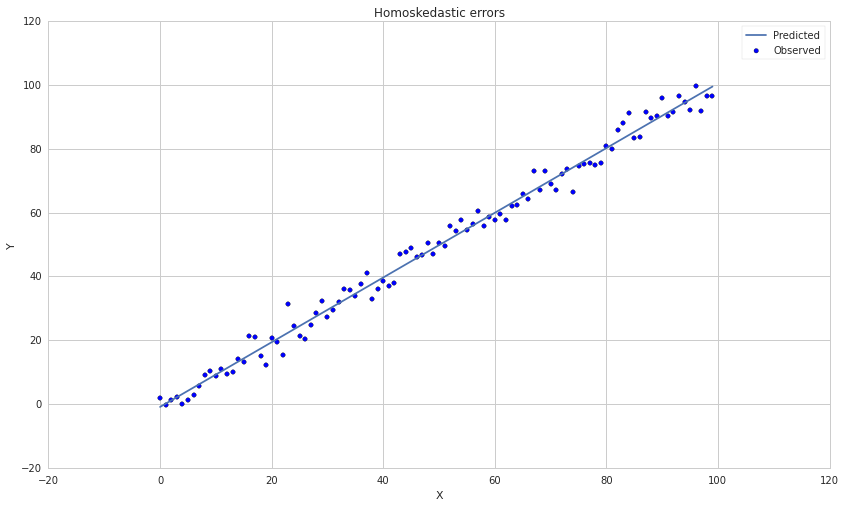

In [3]:
# Artificially create dataset with constant variance around a line
xs = np.arange(100)
y1 = xs + 3*np.random.randn(100)

# Get results of linear regression
slr1 = regression.linear_model.OLS(y1, sm.add_constant(xs)).fit()

# Construct the fit line
fit1 = slr1.params[0] + slr1.params[1]*xs

# Plot data and regression line
plt.scatter(xs, y1)
plt.plot(xs, fit1)
plt.title('Homoskedastic errors');
plt.legend(['Predicted', 'Observed'])
plt.xlabel('X')
plt.ylabel('Y');

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.478
Model:                            OLS   Adj. R-squared:                  0.473
Method:                 Least Squares   F-statistic:                     89.90
Date:                Wed, 05 Aug 2015   Prob (F-statistic):           1.62e-15
Time:                        21:10:57   Log-Likelihood:                -466.94
No. Observations:                 100   AIC:                             937.9
Df Residuals:                      98   BIC:                             943.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          3.0254      5.174      0.585      0.560        -7.242    13.293
x1             0.8561      0.090      9.481      0.000         0.677     1.035
==============================================================================
Omnibus:                       17.388   Durbin-Watson:                   2.551
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               37.198
Skew:                          -0.621   Prob(JB):                     8.37e-09
Kurtosis:                       5.717   Cond. No.                         114.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

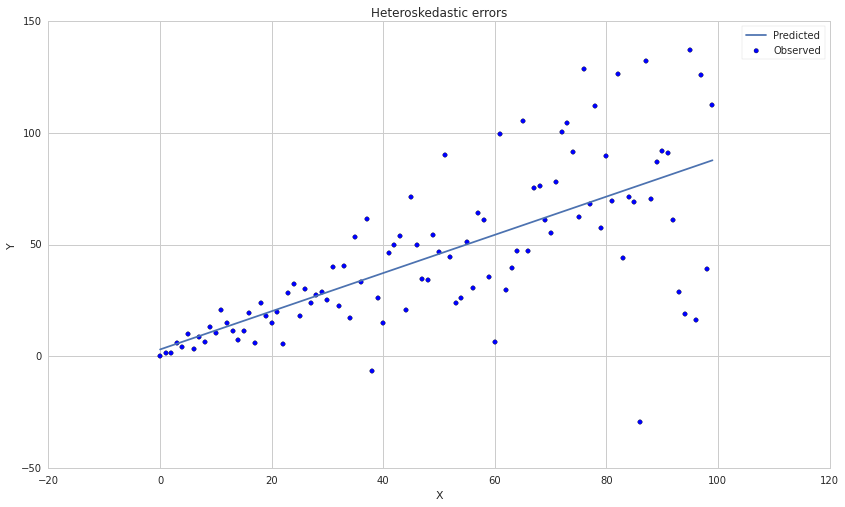

In [4]:
# Artificially create dataset with changing variance around a line
y2 = xs*(1 + .5*np.random.randn(100))

# Perform linear regression
slr2 = regression.linear_model.OLS(y2, sm.add_constant(xs)).fit()
fit2 = slr2.params[0] + slr2.params[1]*xs

# Plot data and regression line
plt.scatter(xs, y2)
plt.plot(xs, fit2)
plt.title('Heteroskedastic errors')
plt.legend(['Predicted', 'Observed'])
plt.xlabel('X')
plt.ylabel('Y')

# Print summary of regression results
slr2.summary()

###Testing for Heteroskedasticity

You can test for heteroskedasticity using a few tests, we'll use the Breush Pagan test from the statsmodels library. We'll also test for normality, which in this case also picks up the weirdness in the second case. HOWEVER, it is possible to have normally distributed residuals which are also heteroskedastic, so both tests must be performed to be sure.

In [5]:
residuals1 = y1-fit1
residuals2 = y2-fit2

xs_with_constant = sm.add_constant(xs)

_, jb_pvalue1, _, _ = statsmodels.stats.stattools.jarque_bera(residuals1)
_, jb_pvalue2, _, _ = statsmodels.stats.stattools.jarque_bera(residuals2)
print "p-value for residuals1 being normal", jb_pvalue1
print "p-value for residuals2 being normal", jb_pvalue2

_, pvalue1, _, _ = stats.diagnostic.het_breushpagan(residuals1, xs_with_constant)
_, pvalue2, _, _ = stats.diagnostic.het_breushpagan(residuals2, xs_with_constant)
print "p-value for residuals1 being heteroskedastic", pvalue1
print "p-value for residuals2 being heteroskedastic", pvalue2

p-value for residuals1 being normal 0.549222677861
p-value for residuals2 being normal 8.36615657932e-09
p-value for residuals1 being heteroskedastic 0.685855818
p-value for residuals2 being heteroskedastic 1.08724617861e-05


###Correcting for Heteroskedasticity

How does heteroskedasticity affect our analysis? The problematic situation, known as conditional heteroskedasticity, is when the error variance is correlated with the independent variables as it is above. This makes the F-test for regression significance and t-tests for the significances of individual coefficients unreliable. Most often this results in overestimation of the significance of the fit.

The Breusch-Pagan test and the White test can be used to detect conditional heteroskedasticity. If we suspect that this effect is present, we can alter our model to try and correct for it. One method is generalized least squares, which requires a manual alteration of the original equation. Another is computing robust standard errors, which corrects the fit statistics to account for the heteroskedasticity. `statsmodels` can compute robust standard errors; note the difference in the statistics below.

In [6]:
print slr2.summary()
print slr2.get_robustcov_results().summary()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.478
Model:                            OLS   Adj. R-squared:                  0.473
Method:                 Least Squares   F-statistic:                     89.90
Date:                Wed, 05 Aug 2015   Prob (F-statistic):           1.62e-15
Time:                        21:10:57   Log-Likelihood:                -466.94
No. Observations:                 100   AIC:                             937.9
Df Residuals:                      98   BIC:                             943.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          3.0254      5.174      0.585      0.5

# Serial correlation of errors

A common and serious problem is when errors are correlated across observations (known serial correlation or autocorrelation). This can occur, for instance, when some of the data points are related, or when we use time-series data with periodic fluctuations. If one of the independent variables depends on previous values of the dependent variable - such as when it is equal to the value of the dependent variable in the previous period - or if incorrect model specification leads to autocorrelation, then the coefficient estimates will be inconsistent and therefore invalid. Otherwise, the parameter estimates will be valid, but the fit statistics will be off. For instance, if the correlation is positive, we will have inflated F- and t-statistics, leading us to overestimate the significance of the model.

If the errors are homoskedastic, we can test for autocorrelation using the Durbin-Watson test, which is conveniently reported in the regression summary in `statsmodels`.

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     Equity(33729 [DAL])   R-squared:                       0.660
Model:                             OLS   Adj. R-squared:                  0.659
Method:                  Least Squares   F-statistic:                     486.2
Date:                 Wed, 05 Aug 2015   Prob (F-statistic):           1.44e-60
Time:                         21:10:58   Log-Likelihood:                -610.08
No. Observations:                  252   AIC:                             1224.
Df Residuals:                      250   BIC:                             1231.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         31.0620      0.344     90.425      0.000        30.385    31.739
x1             0.0522      0.002     22.050      0.000         0.048     0.057
==============================================================================
Omnibus:                       30.398   Durbin-Watson:                   0.085
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               44.557
Skew:                          -0.748   Prob(JB):                     2.11e-10
Kurtosis:                       4.417   Cond. No.                         289.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

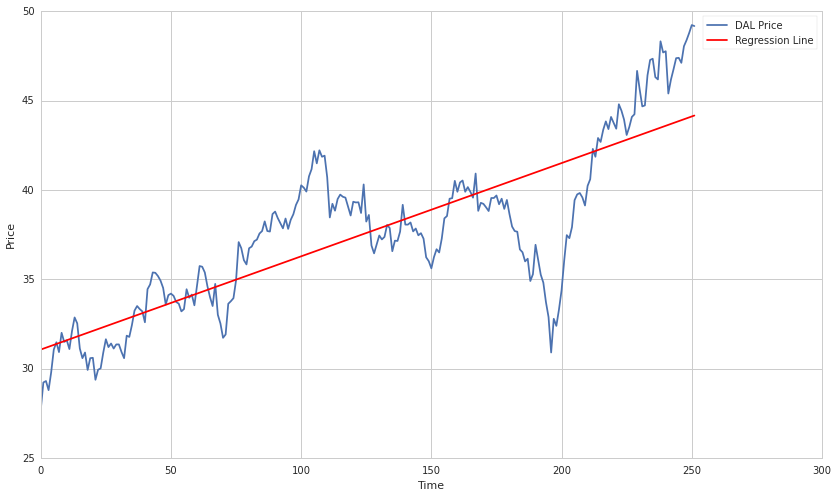

In [7]:
# Load pricing data for an asset
start = '2014-01-01'
end = '2015-01-01'
y = get_pricing('DAL', fields='price', start_date=start, end_date=end)
x = np.arange(len(y))

# Regress pricing data against time
model = regression.linear_model.OLS(y, sm.add_constant(x)).fit()

# Construct the fit line
prediction = model.params[0] + model.params[1]*x

# Plot pricing data and regression line
plt.plot(x,y)
plt.plot(x, prediction, color='r')
plt.legend(['DAL Price', 'Regression Line'])
plt.xlabel('Time')
plt.ylabel('Price')

# Print summary of regression results
model.summary()

###Testing for Autocorrelation

We can test for autocorrelation in both our prices and residuals. We'll use the built-in method to do this, which is based on the Ljun-Box test. This test computes the probability that the n-th lagged datapoint is predictive of the current. If no max lag is given, then the function computes a max lag and returns the p-values for all lags up to that one. We can see here that for the 5 most recent datapoints, a significant correlation exists with the current. Therefore we conclude that both the data is autocorrelated.

We also test for normality for fun.

In [8]:
_, prices_qstats, prices_qstat_pvalues = statsmodels.tsa.stattools.acf(y, qstat=True)
_, prices_qstats, prices_qstat_pvalues = statsmodels.tsa.stattools.acf(y-prediction, qstat=True)

print 'Prices autocorrelation p-values', prices_qstat_pvalues
print 'Residuals autocorrelation p-values', prices_qstat_pvalues

_, jb_pvalue, _, _ = statsmodels.stats.stattools.jarque_bera(y-prediction)

print 'Jarque-Bera p-value that residuals are normally distributed', jb_pvalue

Prices autocorrelation p-values [  9.22951839e-052   6.54325625e-096   1.29666216e-135   1.30651874e-171
   6.92102050e-204   3.24924533e-232   3.23985200e-257   2.96588565e-279
   6.50391089e-299   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000
   0.00000000e+000   0.00000000e+000   0.00000000e+000   0.00000000e+000]
Residuals autocorrelation p-values [  9.22951839e-052   6.54325625e-096   1.29666216e-135   1.30651874e-171
   6.92102050e-204   3.24924533e-232   3.23985200e-257   2.96588565e-279
   6.50391089e-299   0.00000000e+000   0.00000000e+000  

##Newey-West

Newey-West is a method of computing variance which accounts for autocorrelation. A naive variance computation will actually produce inaccurate standard errors with the presence of autocorrelation.

We can attempt to change the regression equation to eliminate serial correlation. A simpler fix is adjusting the standard errors using an appropriate method and using the adjusted values to check for significance. Below we use the Newey-West method from `statsmodels` to compute adjusted standard errors for the coefficients. They are higher than those originally reported by the regression, which is what we expected for positively correlated errors.

In [9]:
from math import sqrt

# Find the covariance matrix of the coefficients
cov_mat = stats.sandwich_covariance.cov_hac(model)

# Print the standard errors of each coefficient from the original model and from the adjustment
print 'Old standard errors:', model.bse[0], model.bse[1]
print 'Adjusted standard errors:', sqrt(cov_mat[0,0]), sqrt(cov_mat[1,1])

Old standard errors: 0.343510916163 0.00236807424591
Adjusted standard errors: 0.507679344438 0.00511956168035


 # Multicollinearity

When using multiple independent variables, it is important to check for multicollinearity; that is, an approximate linear relation between the independent variables, such as
$$ X_2 \approx 5 X_1 - X_3 + 4.5 $$

With multicollinearity, it is difficult to identify the independent effect of each variable, since we can change around the coefficients according to the linear relation without changing the model. As with truly unnecessary variables, this will usually not hurt the accuracy of the model, but will cloud our analysis. In particular, the estimated coefficients will have large standard errors. The coefficients will also no longer represent the partial effect of each variable, since with multicollinearity we cannot change one variable while holding the others constant.

High correlation between independent variables is indicative of multicollinearity. However, it is not enough, since we would want to detect correlation between one of the variables and a linear combination of the other variables. If we have high R-squared but low t-statistics on the coefficients (the fit is good but the coefficients are not estimated precisely) we may suspect multicollinearity. To resolve the problem, we can drop one of the independent variables involved in the linear relation.

For instance, using two stock indices as our independent variables is likely to lead to multicollinearity. Below we can see that removing one of them improves the t-statistics without hurting R-squared.

Another important thing to determine here is which variable may be the casual one. If we hypothesize that the market influences both MDY and HPQ, then the market is the variable that we should use in our predictive model.

R-squared: 0.887802860768
t-statistics of coefficients:
const   -11.676469
x1       24.201404
x2       -5.862084
dtype: float64


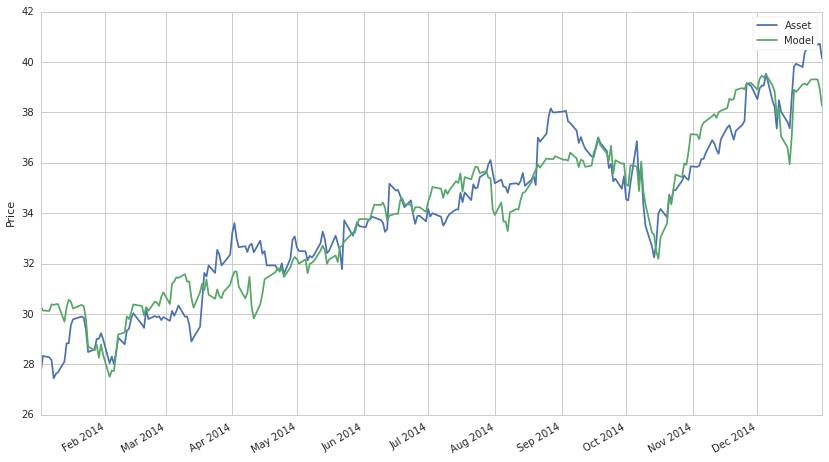

In [10]:
# Load pricing data for asset and two market indices
start = '2014-01-01'
end = '2015-01-01'
b1 = get_pricing('SPY', fields='price', start_date=start, end_date=end)
b2 = get_pricing('MDY', fields='price', start_date=start, end_date=end)
a = get_pricing('HPQ', fields='price', start_date=start, end_date=end)

# Run multiple linear regression
mlr = regression.linear_model.OLS(a, sm.add_constant(np.column_stack((b1,b2)))).fit()

# Construct fit curve using dependent variables and estimated coefficients
mlr_prediction = mlr.params[0] + mlr.params[1]*b1 + mlr.params[2]*b2

# Print regression statistics 
print 'R-squared:', mlr.rsquared_adj
print 't-statistics of coefficients:\n', mlr.tvalues

# Plot asset and model
a.plot()
mlr_prediction.plot()
plt.legend(['Asset', 'Model']);
plt.ylabel('Price')

R-squared: 0.872829465873
t-statistics of coefficients:
const                -21.616393
Equity(8554 [SPY])    41.517799
dtype: float64


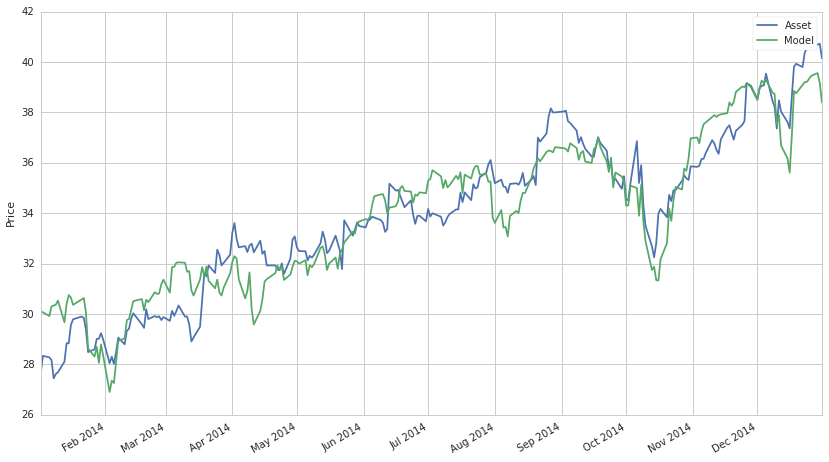

In [11]:
# Perform linear regression
slr = regression.linear_model.OLS(a, sm.add_constant(b1)).fit()
slr_prediction = slr.params[0] + slr.params[1]*b1

# Print fit statistics
print 'R-squared:', slr.rsquared_adj
print 't-statistics of coefficients:\n', slr.tvalues

# Plot asset and model
a.plot()
slr_prediction.plot()
plt.ylabel('Price')
plt.legend(['Asset', 'Model']);

# Example: Anscombe's quartet

Anscombe constructed 4 datasets which not only have the same mean and variance in each variable, but also the same correlation coefficient, regression line, and R-squared regression value. Below, we test this result as well as plotting the datasets. A quick glance at the graphs shows that only the first dataset satisfies the regression model assumptions. Consequently, the high R-squared values of the other three are not meaningful, which agrees with our intuition that the other three are not modeled well by the lines of best fit.

Cofficients: [ 3.00009091  0.50009091] [ 3.00090909  0.5       ] [ 3.00245455  0.49972727] [ 3.00172727  0.49990909]
Pearson r: 0.816420516345 0.816236506 0.81628673949 0.816521436889
R-squared: 0.666542459509 0.666242033727 0.666324041067 0.666707256898


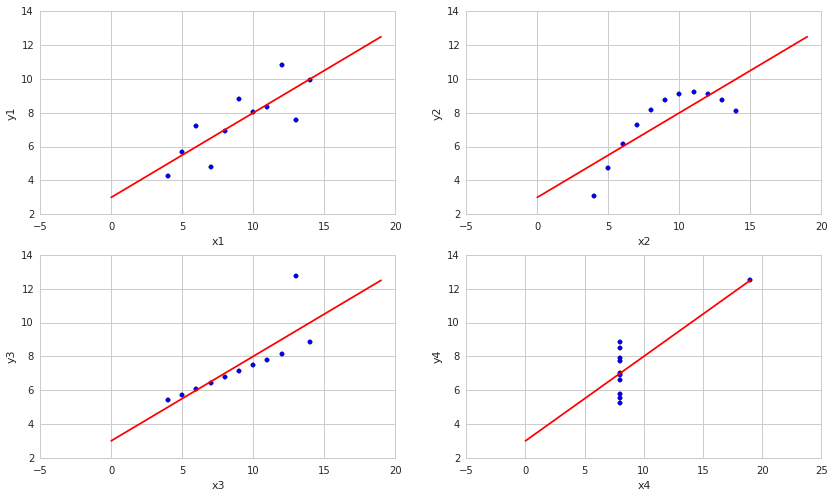

In [12]:
from scipy.stats import pearsonr

# Construct Anscombe's arrays
x1 = [10, 8, 13, 9, 11, 14, 6, 4, 12, 7, 5]
y1 = [8.04, 6.95, 7.58, 8.81, 8.33, 9.96, 7.24, 4.26, 10.84, 4.82, 5.68]
x2 = [10, 8, 13, 9, 11, 14, 6, 4, 12, 7, 5]
y2 = [9.14, 8.14, 8.74, 8.77, 9.26, 8.10, 6.13, 3.10, 9.13, 7.26, 4.74]
x3 = [10, 8, 13, 9, 11, 14, 6, 4, 12, 7, 5]
y3 = [7.46, 6.77, 12.74, 7.11, 7.81, 8.84, 6.08, 5.39, 8.15, 6.42, 5.73]
x4 = [8, 8, 8, 8, 8, 8, 8, 19, 8, 8, 8]
y4 = [6.58, 5.76, 7.71, 8.84, 8.47, 7.04, 5.25, 12.50, 5.56, 7.91, 6.89]

# Perform linear regressions on the datasets
slr1 = regression.linear_model.OLS(y1, sm.add_constant(x1)).fit()
slr2 = regression.linear_model.OLS(y2, sm.add_constant(x2)).fit()
slr3 = regression.linear_model.OLS(y3, sm.add_constant(x3)).fit()
slr4 = regression.linear_model.OLS(y4, sm.add_constant(x4)).fit()

# Print regression coefficients, Pearson r, and R-squared for the 4 datasets
print 'Cofficients:', slr1.params, slr2.params, slr3.params, slr4.params
print 'Pearson r:', pearsonr(x1, y1)[0], pearsonr(x2, y2)[0], pearsonr(x3, y3)[0], pearsonr(x4, y4)[0]
print 'R-squared:', slr1.rsquared, slr2.rsquared, slr3.rsquared, slr4.rsquared

# Plot the 4 datasets with their regression lines
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)
xs = np.arange(20)
ax1.plot(slr1.params[0] + slr1.params[1]*xs, 'r')
ax1.scatter(x1, y1)
ax1.set_xlabel('x1')
ax1.set_ylabel('y1')
ax2.plot(slr2.params[0] + slr2.params[1]*xs, 'r')
ax2.scatter(x2, y2)
ax2.set_xlabel('x2')
ax2.set_ylabel('y2')
ax3.plot(slr3.params[0] + slr3.params[1]*xs, 'r')
ax3.scatter(x3, y3)
ax3.set_xlabel('x3')
ax3.set_ylabel('y3')
ax4.plot(slr4.params[0] + slr4.params[1]*xs, 'r')
ax4.scatter(x4,y4)
ax4.set_xlabel('x4')
ax4.set_ylabel('y4');

*This presentation is for informational purposes only and does not constitute an offer to sell, a solicitation to buy, or a recommendation for any security; nor does it constitute an offer to provide investment advisory or other services by Quantopian, Inc. ("Quantopian"). Nothing contained herein constitutes investment advice or offers any opinion with respect to the suitability of any security, and any views expressed herein should not be taken as advice to buy, sell, or hold any security or as an endorsement of any security or company.  In preparing the information contained herein, Quantopian, Inc. has not taken into account the investment needs, objectives, and financial circumstances of any particular investor. Any views expressed and data illustrated herein were prepared based upon information, believed to be reliable, available to Quantopian, Inc. at the time of publication. Quantopian makes no guarantees as to their accuracy or completeness. All information is subject to change and may quickly become unreliable for various reasons, including changes in market conditions or economic circumstances.*